# ASMSA: Train AAE model with the tuned hyperparameters

**Previous steps**
- [prepare.ipynb](prepare.ipynb): Download and sanity check input files
- [tune.ipynb](tune.ipynb): Perform initial hyperparameter tuning for this molecule

**Next step**
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

## Notebook setup

In [1]:
#%cd villin

In [2]:
threads = 2
import os
os.environ['OMP_NUM_THREADS']=str(threads)
import tensorflow as tf

# PyTorch favours OMP_NUM_THREADS in environment
import torch

# Tensorflow needs explicit cofig calls
tf.config.threading.set_inter_op_parallelism_threads(threads)
tf.config.threading.set_intra_op_parallelism_threads(threads)

2025-03-13 10:40:16.582320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-13 10:40:16.595854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-13 10:40:16.600242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 10:40:16.610694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 10:40:17.354964: W tensorflow/compiler/tf2

In [3]:
from asmsa.tuning_analyzer import TuningAnalyzer
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import urllib.request
from tensorflow import keras
import keras_tuner
import asmsa.visualizer as visualizer
import asmsa

2025-03-13 10:40:19.267094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1201 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0


## Input files

All input files are prepared (up- or downloaded) in [prepare.ipynb](prepare.ipynb). 


In [4]:
exec(open('inputs.py').read())

## Apply the tuning results

In [14]:
# pick from plots in tune.ipynb

best_enc_seed=128
best_disc_seed=32

In [15]:
# Get best HP from latest tuning
analyzer = TuningAnalyzer()
analyzer.get_best_hp(num_trials=3)

Analyzing tuning from: /home/jovyan/ASMSA/analysis/03122025-093638/
Printing results of tuning: /home/jovyan/ASMSA/analysis/03122025-093638/
-----(1)-----
Trial ID: 12c1b6ec1399aa69e11f26db6a259695c37aea7bd2d7c532e7d82d2ca348fb6c
Hyperparameters:
activation: selu
ae_number_of_layers: 2
disc_number_of_layers: 3
batch_size: 256
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.11849422874465325
-----(2)-----
Trial ID: f01da9ffc5e67361dd119ad660fbaba56d645047a3d1eada23a22abe906e5279
Hyperparameters:
activation: selu
ae_number_of_layers: 4
disc_number_of_layers: 5
batch_size: 256
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.14481843415139278
-----(3)-----
Trial ID: 2088c4470769562dc2a02155700966cf5d18ef8c5c0e5d8ed51875662b156aa1
Hyperparameters:
activation: selu
ae_number_of_layers: 4
disc_number_of_layers: 3
batch_size: 256
optimizer: Adam
learning_rate: 0.0002
ae_los

In [16]:
medium_hp = {
    'activation' : 'selu',
    'ae_neuron_number_seed' : 128,
    'disc_neuron_number_seed' : 32,
    'ae_number_of_layers' : 2,
    'disc_number_of_layers' : 3,
    'batch_size' : 128,
    'optimizer' : 'Adam',
    'learning_rate' : 0.0002,
    'ae_loss_fn' : 'MeanSquaredError',
    'disc_loss_fn' : 'BinaryCrossentropy'
}

hps = medium_hp

    
print(hps)

{'activation': 'selu', 'ae_neuron_number_seed': 128, 'disc_neuron_number_seed': 32, 'ae_number_of_layers': 2, 'disc_number_of_layers': 3, 'batch_size': 128, 'optimizer': 'Adam', 'learning_rate': 0.0002, 'ae_loss_fn': 'MeanSquaredError', 'disc_loss_fn': 'BinaryCrossentropy'}


In [17]:
# Select HP to use by specifying trial_id
#  e.g: trial_id = '483883b929b3445bff6dee9759c4d50ee3a4ba7f0db22e665c49b5f942d9693b'
# ... or don't specify, by default use the trial with the lowest score
trial_id = ''

hps = hps
for trial in analyzer.sorted_trials:
    if trial['trial_id'] == trial_id:
        hps = trial['hp']
    
if not hps:
    print(f'Could not find trial with specified ID, using one with the lowest score - {analyzer.sorted_trials[0]["trial_id"]}')
    hps = analyzer.sorted_trials[0]['hp']
    
print(hps)

{'activation': 'selu', 'ae_neuron_number_seed': 128, 'disc_neuron_number_seed': 32, 'ae_number_of_layers': 2, 'disc_number_of_layers': 3, 'batch_size': 128, 'optimizer': 'Adam', 'learning_rate': 0.0002, 'ae_loss_fn': 'MeanSquaredError', 'disc_loss_fn': 'BinaryCrossentropy'}


## Load datasets
Load filtered trajectory datasets that were processed in **prepare.ipynb**. Trajectories are in internal coordinates format.

In [18]:
# load train dataset
X_train = tf.data.Dataset.load('datasets/intcoords/train')

# get batched version of dataset to feed to AAE model for training
X_train_batched = X_train.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for visualization purposes
X_train_np = np.stack(list(X_train))
X_train_np.shape

2025-03-13 07:10:46.331116: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(7000, 3448)

In [19]:
# load test dataset
X_test = tf.data.Dataset.load('datasets/intcoords/test')

# get batched version of dataset to feed to AAE model for prediction
X_test_batched = X_test.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for testing purposes
X_test_np = np.stack(list(X_test))
X_test_np.shape

(1501, 3448)

In [20]:
X_val = tf.data.Dataset.load('datasets/intcoords/validate')

X_val_batched = X_test.batch(hps['batch_size'],drop_remainder=True)

X_val_np = np.stack(list(X_val))
X_val_np.shape


(1500, 3448)

## Train

### Distribution prior
Train with common prior distributions. See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions for all available distributions. It is ideal to use tuned Hyperparameters for training.

In [21]:
# set used prior

# this one is (more or less) required to with the density alignment
#prior = tfp.distributions.MultivariateNormalDiag(loc=[0.,0.])

prior = tfp.distributions.Normal(loc=0, scale=1)
# prior = tfp.distributions.Uniform()
# prior = tfp.distributions.Weibull(1,0.5)
# prior = tfp.distributions.Cauchy(loc=0, scale=1)

In [22]:
# prepare model using the best hyperparameters
testm = asmsa.AAEModel((X_train_np.shape[1],),
                       prior=prior,
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       with_density=False
                      )
testm.compile()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [23]:
testm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_0 (Dense)                   │ (None, 128)            │       441,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_1 (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_2 (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_2 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_out (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_3 (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_3 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_1 (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_0 (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_out (Dense)                 │ (None, 3448)           │       444,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 3448)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 908,986 (3.47 MB)

 Trainable params: 908,090 (3.46 MB)

 Non-trainable params: 896 (3.50 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_0 (Dense)                  │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_0 (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_1 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_1 (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_2 (Dense)                  │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_2 (LeakyReLU)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_3 (Dense)                  │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_3 (LeakyReLU)         │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_out (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
testm.enc.layers[3].activation

<function keras.src.activations.activations.selu(x)>

In [26]:
# specify earlystopping callback to avoid overfitting
monitored_metric = "AE loss min"
#monitored_metric = 'val_loss'

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor=monitored_metric,
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

Epoch 1/1000


I0000 00:00:1741849896.108640  299928 service.cc:146] XLA service 0x732d440030d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741849896.108691  299928 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2025-03-13 07:11:36.203485: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. StatefulPartitionedCall/random_uniform/RandomUniform
2025-03-13 07:11:36.240025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-13 07:11:36.662150: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-03-13 07:11:41.819174: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler

54/54 - 11s - 210ms/step - AE loss max: 0.9788 - AE loss min: 0.9788 - cheat loss max: 0.2529 - cheat loss min: 0.2529 - density loss: 42.0000 - disc loss max: -7.9909e-02 - disc loss min: -7.9909e-02
Epoch 2/1000
54/54 - 0s - 3ms/step - AE loss max: 0.9819 - AE loss min: 0.9819 - cheat loss max: 0.0635 - cheat loss min: 0.0635 - density loss: 42.0000 - disc loss max: 0.0610 - disc loss min: 0.0610
Epoch 3/1000
54/54 - 0s - 3ms/step - AE loss max: 0.9457 - AE loss min: 0.9457 - cheat loss max: -1.4986e-02 - cheat loss min: -1.4986e-02 - density loss: 42.0000 - disc loss max: 0.0432 - disc loss min: 0.0432
Epoch 4/1000
54/54 - 0s - 3ms/step - AE loss max: 0.9404 - AE loss min: 0.9404 - cheat loss max: -3.7019e-02 - cheat loss min: -3.7019e-02 - density loss: 42.0000 - disc loss max: 0.0208 - disc loss min: 0.0208
Epoch 5/1000
54/54 - 0s - 3ms/step - AE loss max: 0.9377 - AE loss min: 0.9377 - cheat loss max: -4.1663e-02 - cheat loss min: -4.1663e-02 - density loss: 42.0000 - disc loss m

/opt/conda/lib/python3.10/site-packages/asmsa/visualizer.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0][0].scatter(x, y, s=0.1, cmap=self.cmap)


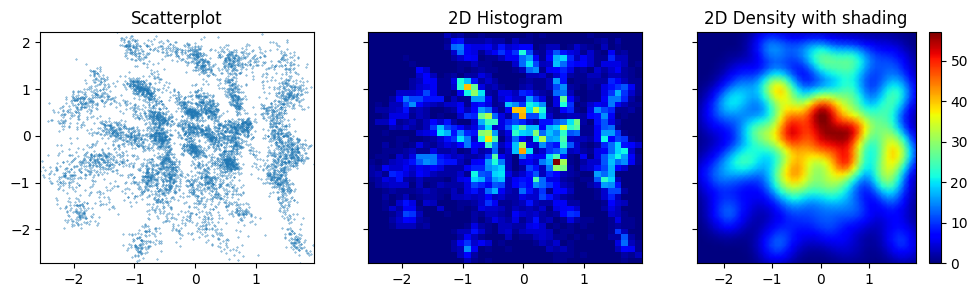

54/54 - 1s - 18ms/step - AE loss max: 0.8590 - AE loss min: 0.8590 - cheat loss max: -1.9153e-01 - cheat loss min: -1.9153e-01 - density loss: 42.0000 - disc loss max: -1.5752e-03 - disc loss min: -1.5752e-03
Epoch 101/1000
54/54 - 0s - 3ms/step - AE loss max: 0.8595 - AE loss min: 0.8595 - cheat loss max: -1.8857e-01 - cheat loss min: -1.8857e-01 - density loss: 42.0000 - disc loss max: -5.7355e-04 - disc loss min: -5.7355e-04
Epoch 102/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8603 - AE loss min: 0.8603 - cheat loss max: -1.8812e-01 - cheat loss min: -1.8812e-01 - density loss: 42.0000 - disc loss max: -1.9179e-04 - disc loss min: -1.9179e-04
Epoch 103/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8605 - AE loss min: 0.8605 - cheat loss max: -1.9165e-01 - cheat loss min: -1.9165e-01 - density loss: 42.0000 - disc loss max: 7.4971e-04 - disc loss min: 7.4971e-04
Epoch 104/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8603 - AE loss min: 0.8603 - cheat loss max: -1.9342e-01 - cheat loss 

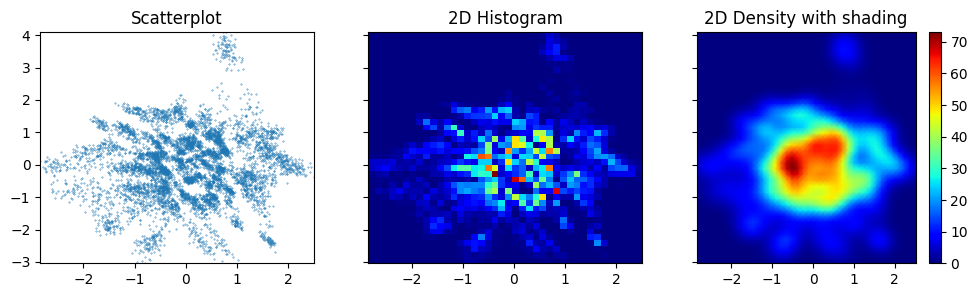

54/54 - 1s - 20ms/step - AE loss max: 0.8489 - AE loss min: 0.8489 - cheat loss max: -2.6014e-01 - cheat loss min: -2.6014e-01 - density loss: 42.0000 - disc loss max: 3.6538e-04 - disc loss min: 3.6538e-04
Epoch 201/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8485 - AE loss min: 0.8485 - cheat loss max: -2.6494e-01 - cheat loss min: -2.6494e-01 - density loss: 42.0000 - disc loss max: 3.5602e-04 - disc loss min: 3.5602e-04
Epoch 202/1000
54/54 - 0s - 3ms/step - AE loss max: 0.8481 - AE loss min: 0.8481 - cheat loss max: -2.6734e-01 - cheat loss min: -2.6734e-01 - density loss: 42.0000 - disc loss max: -1.4758e-03 - disc loss min: -1.4758e-03
Epoch 203/1000
54/54 - 0s - 3ms/step - AE loss max: 0.8483 - AE loss min: 0.8483 - cheat loss max: -2.6772e-01 - cheat loss min: -2.6772e-01 - density loss: 42.0000 - disc loss max: -5.4461e-04 - disc loss min: -5.4461e-04
Epoch 204/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8484 - AE loss min: 0.8484 - cheat loss max: -2.6673e-01 - cheat loss mi

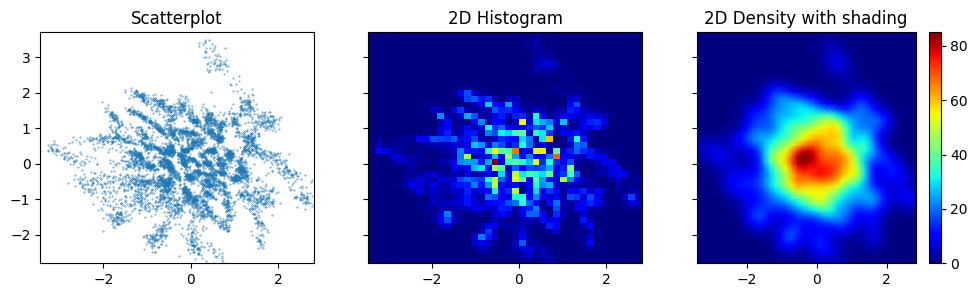

54/54 - 1s - 14ms/step - AE loss max: 0.8405 - AE loss min: 0.8405 - cheat loss max: -3.5731e-01 - cheat loss min: -3.5731e-01 - density loss: 42.0000 - disc loss max: -7.5811e-04 - disc loss min: -7.5811e-04
Epoch 301/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8401 - AE loss min: 0.8401 - cheat loss max: -3.5855e-01 - cheat loss min: -3.5855e-01 - density loss: 42.0000 - disc loss max: -5.8851e-04 - disc loss min: -5.8851e-04
Epoch 302/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8399 - AE loss min: 0.8399 - cheat loss max: -3.6848e-01 - cheat loss min: -3.6848e-01 - density loss: 42.0000 - disc loss max: 0.0028 - disc loss min: 0.0028
Epoch 303/1000
54/54 - 0s - 6ms/step - AE loss max: 0.8400 - AE loss min: 0.8400 - cheat loss max: -3.5651e-01 - cheat loss min: -3.5651e-01 - density loss: 42.0000 - disc loss max: 6.3777e-06 - disc loss min: 6.3777e-06
Epoch 304/1000
54/54 - 0s - 3ms/step - AE loss max: 0.8397 - AE loss min: 0.8397 - cheat loss max: -3.4964e-01 - cheat loss min: -3.49

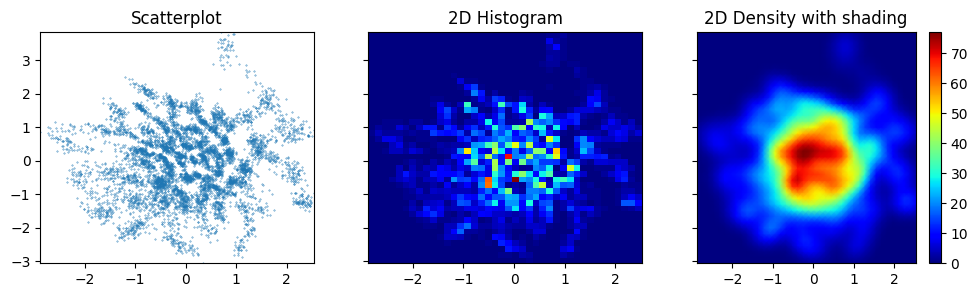

54/54 - 1s - 15ms/step - AE loss max: 0.8357 - AE loss min: 0.8357 - cheat loss max: -3.5661e-01 - cheat loss min: -3.5661e-01 - density loss: 42.0000 - disc loss max: 0.0012 - disc loss min: 0.0012
Epoch 401/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8347 - AE loss min: 0.8347 - cheat loss max: -3.5335e-01 - cheat loss min: -3.5335e-01 - density loss: 42.0000 - disc loss max: 0.0022 - disc loss min: 0.0022
Epoch 402/1000
54/54 - 0s - 3ms/step - AE loss max: 0.8348 - AE loss min: 0.8348 - cheat loss max: -3.4953e-01 - cheat loss min: -3.4953e-01 - density loss: 42.0000 - disc loss max: -2.1315e-03 - disc loss min: -2.1315e-03
Epoch 403/1000
54/54 - 0s - 3ms/step - AE loss max: 0.8345 - AE loss min: 0.8345 - cheat loss max: -3.5016e-01 - cheat loss min: -3.5016e-01 - density loss: 42.0000 - disc loss max: 6.0380e-05 - disc loss min: 6.0380e-05
Epoch 404/1000
54/54 - 0s - 4ms/step - AE loss max: 0.8345 - AE loss min: 0.8345 - cheat loss max: -3.3886e-01 - cheat loss min: -3.3886e-01 - d

In [27]:
# train it (can be repeated several times to add more epochs)

testm.fit(X_train_batched,
          epochs=1000,
          verbose=2, # this flag is essential due to connection with EarlyStopping callback (epoch vs batch)
          callbacks=[
              early_stop_cb,
              visualizer.VisualizeCallback(testm,freq=100,inputs=X_train_np,figsize=(12,3))
          ])

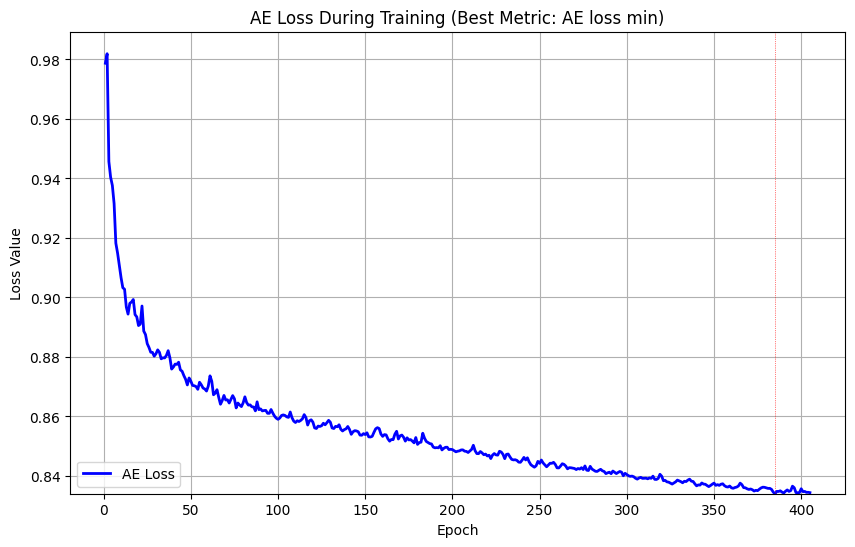

In [28]:
# Assuming 'monitored_metric' is defined and you have your history
since_epoch = 1

assert since_epoch > 0
history = np.array(testm.history.history['AE loss max'])
y = history[since_epoch-1:]
x = list(range(since_epoch, len(y) + since_epoch))

# Find the epochs with the minimum loss
result = np.array(list(map(lambda x: x + 1, np.where(history == history.min())[0])))  # Add +1 to convert index to epoch

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='AE Loss', color='blue', linewidth=2)

# Vertical lines for epochs with minimum loss
[plt.axvline(_x, linewidth=0.5, color='red', linestyle=':') for _x in result]

# Highlight the minimum loss value for annotation
min_loss_epoch = result[0]
min_loss_value = y[min_loss_epoch - since_epoch]

# Set limits for Y-axis
plt.ylim(bottom=min_loss_value)  # Start Y-axis at the minimum loss value

# Add gridlines
plt.grid(True)

# Add title and labels
plt.title(f'AE Loss During Training (Best Metric: {monitored_metric})')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Show the plot
plt.show()

In [29]:
# whatever test
''' 
batch_size = 256

val_result = testm.predict(X_test_batched)
mse = keras.losses.MeanSquaredError()
dataset_size = X_test_np.shape[0]
print(dataset_size)
mse_result=[]
for i in range(0, dataset_size, batch_size):
    if i+batch_size > dataset_size:
        batch_size = batch_size-(i+batch_size-dataset_size)
    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()
    mse_result.append(batch_mse)

mse_result'''

' \nbatch_size = 256\n\nval_result = testm.predict(X_test_batched)\nmse = keras.losses.MeanSquaredError()\ndataset_size = X_test_np.shape[0]\nprint(dataset_size)\nmse_result=[]\nfor i in range(0, dataset_size, batch_size):\n    if i+batch_size > dataset_size:\n        batch_size = batch_size-(i+batch_size-dataset_size)\n    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()\n    mse_result.append(batch_mse)\n\nmse_result'

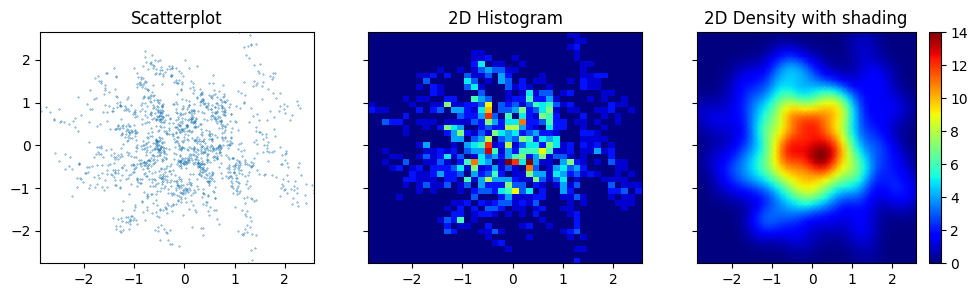

In [30]:
# final visualization, pick a slice of the input data for demo purposes
#visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np[15000:20000]).numpy())

# on test data
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_test_np).numpy())

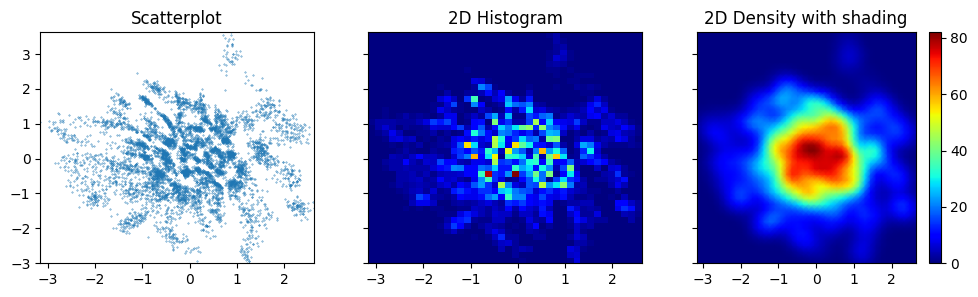

In [31]:
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np).numpy())

In [32]:
# load testing trajectory for further visualizations and computations
tr = md.load('prepare_data/x_train.xtc',top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like Ala-Ala, where superposing on CAs fails
#idx=tr[0].top.select("element != H") 

tr.superpose(tr[0],atom_indices=idx)

# reshuffle the geometry to get frame last so that we can use vectorized calculations
geom = np.moveaxis(tr.xyz ,0,-1)
geom.shape

(1565, 3, 7000)

(10001, 3448)


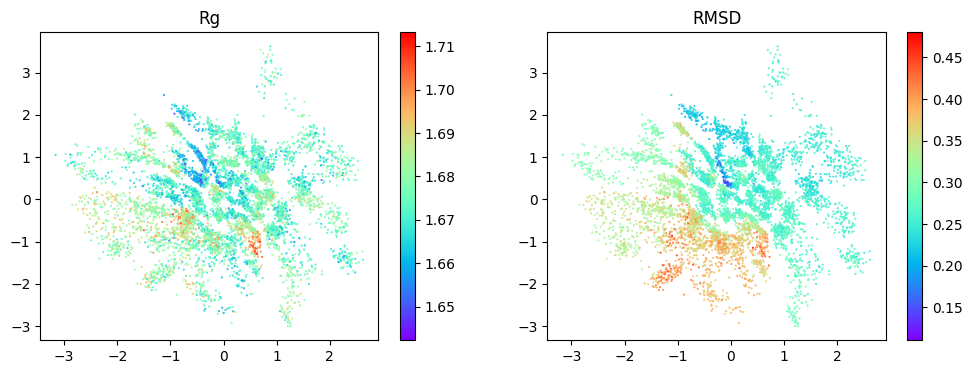

In [33]:
# Rgyr and rmsd color coded in low dim (rough view)
X_all_np = np.concatenate([X_train_np, X_test_np, X_val_np], axis=0)
print(X_all_np.shape)

lows = testm.call_enc(X_train_np).numpy()
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

In [174]:
# not used
'''testm.enc.save('enc.keras')
testm.dec.save('dec.keras')
testm.disc.save('dec.keras')'''

"testm.enc.save('enc.keras')\ntestm.dec.save('dec.keras')\ntestm.disc.save('dec.keras')"

### Image prior

**Almost surely broken now with the density alignment**

Use Image as a prior distribution. Again use tuned Hyperparameters for better training performance.

In [ ]:
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1I2WP92MMWS5s5vin_4cvmruuV-1W77Hl", "mushroom_bw.png")

In [ ]:
mmush = asmsa.AAEModel((X_train_np.shape[1],),
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       prior='mushroom_bw.png'
                      )
mmush.compile()

In [ ]:
mmush.fit(X_train_batched,
          epochs=500,
          verbose=2,
          callbacks=[
              early_stop_cb,
              visualizer.VisualizeCallback(mmush,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

In [ ]:
# - plot AE loss min during training
# - specify "since_epoch" for better plot scaling (ignore outliers)
# - note that numbering of epochs starts at 1, 0th epoch does not exist
since_epoch = 1
monitored_metric = 'AE loss min'

assert since_epoch > 0
history = np.array(mmush.history.history[monitored_metric])
y = history[since_epoch-1:]
x = list(range(since_epoch, len(y)+since_epoch))
result = np.array(list(map(lambda x: x+1, np.where(history == history.min())[0]))) # add +1 to convert index to epoch

[plt.axvline(_x, linewidth=0.5, color='r', ls=':') for _x in result]
plt.plot(x, y)
plt.title(f'Best weights for metric [{monitored_metric}] at epoch/s {result}')
plt.show()

In [ ]:
batch_size = 256

val_result = testm.predict(X_test_batched)
mse = keras.losses.MeanSquaredError()
dataset_size = X_test_np.shape[0]
print(dataset_size)
mse_result=[]
for i in range(0, dataset_size, batch_size):
    if i+batch_size > dataset_size:
        batch_size = batch_size-(i+batch_size-dataset_size)
    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()
    mse_result.append(batch_mse)

mse_result

In [ ]:
step=4
tr2 = tr[::step]
lows = mmush.call_enc(X_test_np[::step]).numpy()
rg = md.compute_rg(tr2)
base = md.load(conf)
rmsd = md.rmsd(tr2,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

## Save the encoder and decoder models

In [34]:
import tf2onnx
import onnx2torch
import tempfile

def _convert_to_onnx(model, destination_path):
#    model = keras.models.load_model(source_path)

    input_tensor = model.layers[0]._input_tensor
#    input_tensor = model.inputs[0]
    input_signature = tf.TensorSpec(
        name=input_tensor.name, shape=input_tensor.shape, dtype=input_tensor.dtype
    )
    output_name = model.layers[-1].name

    @tf.function(input_signature=[input_signature])
    def _wrapped_model(input_data):
        return {output_name: model(input_data)}

    tf2onnx.convert.from_function(
        _wrapped_model, input_signature=[input_signature], output_path=destination_path
    )

In [35]:
model = testm

In [36]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.enc,onnx.name)
    torch_enc = onnx2torch.convert(onnx.name)

example_input = torch.randn([X_train_np.shape[1]])
traced_script_module = torch.jit.trace(torch_enc, example_input)

traced_script_module.save('encoder.pt')

I0000 00:00:1741849993.337016  299906 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-03-13 07:13:13.337272: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-03-13 07:13:13.342755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1201 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
2025-03-13 07:13:13.419275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1201 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
I0000 00:00:1741849993.426761  299906 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-03-13 07:13:13.426915: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting ne

In [37]:
example_input.shape

torch.Size([3448])

In [38]:
model.enc.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_0 (Dense)                   │ (None, 128)            │       441,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_1 (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_2 (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_2 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_out (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,770 (1.73 MB)

 Trainable params: 452,322 (1.73 MB)

 Non-trainable params: 448 (1.75 KB)

In [39]:
lenc = torch.jit.load('encoder.pt')
example_input = np.random.rand(10000,X_train_np.shape[1])
rtf = model.enc(example_input)
rpt = lenc(torch.tensor(example_input,dtype=torch.float32))

In [40]:
maxerr = np.max(np.abs(rtf - rpt.detach().numpy()))
maxerr

0.000576552

In [41]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.dec,onnx.name)
    torch_dec = onnx2torch.convert(onnx.name)

example_input = torch.randn([2])
traced_script_module = torch.jit.trace(torch_dec, example_input)

traced_script_module.save('decoder.pt')

I0000 00:00:1741849994.685990  299906 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-03-13 07:13:14.686241: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-03-13 07:13:14.692794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1201 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
2025-03-13 07:13:14.762042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1201 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
I0000 00:00:1741849994.773299  299906 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-03-13 07:13:14.773450: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting ne

In [42]:
ldec = torch.jit.load('decoder.pt')
example_input = np.random.rand(10000,2)
rtf = model.dec(example_input)
rpt = ldec(torch.tensor(example_input,dtype=torch.float32))

In [43]:
err = np.abs(rtf - rpt.detach().numpy())
train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32).reshape(1,1,-1)
rerr = err/np.abs(train_mean)
np.max(err),np.max(rerr)

(0.0166139, 11.0062685)

# Visualize

In [5]:
test_geom = np.moveaxis(np.stack(list(tf.data.Dataset.load('datasets/geoms/test'))),2,0)
train_geom = np.moveaxis(np.stack(list(tf.data.Dataset.load('datasets/geoms/train'))),2,0)
val_geom = np.moveaxis(np.stack(list(tf.data.Dataset.load('datasets/geoms/validate'))),2,0)

all_geom = np.concatenate([train_geom, test_geom, val_geom], axis=0)

all_geom.shape

2025-03-13 10:40:35.456211: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-13 10:40:35.667381: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(10001, 1565, 3)

In [6]:
mol_model = torch.jit.load('features.pt')
torch_encoder = torch.jit.load('encoder.pt')

train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32)
train_scale = np.loadtxt('datasets/intcoords/scale.txt',dtype=np.float32)

class CompleteModel(torch.nn.Module):
    def __init__(self, mol_model, torch_encoder, train_mean, train_scale):
        super(CompleteModel, self).__init__()
        self.mol_model = mol_model
        self.torch_encoder = torch_encoder
        # Convert train_mean and train_scale from numpy to torch tensors
        self.train_mean = torch.from_numpy(np.reshape(train_mean, (-1, 1)))
        self.train_scale = torch.from_numpy(np.reshape(train_scale, (-1, 1)))

    def forward(self, x):
        mol_output = self.mol_model(x.moveaxis(0,-1))
        normalized = (mol_output - self.train_mean) / self.train_scale
#        reshaped = normalized.reshape(-1)
        return self.torch_encoder(normalized.T)

# Initialize the CompleteModel class with your components
complete_model = CompleteModel(mol_model, torch_encoder, train_mean, train_scale)

# Save the Torch model using TorchScript trace
example_input = torch.randn([1,test_geom.shape[1], test_geom.shape[2]])
traced_script_module = torch.jit.trace(complete_model, example_input)

model_file_name = "model.pt"
traced_script_module.save(model_file_name)

In [7]:
m = torch.jit.load('model.pt')
lows_train = m(torch.tensor(train_geom)).numpy()
lows_test = m(torch.tensor(test_geom)).numpy()
lows_val = m(torch.tensor(val_geom)).numpy()
lows_all = np.concatenate([lows_train, lows_test, lows_val], axis=0)


In [8]:
lows_all.shape

(10001, 2)

In [19]:
#x = md.load('prepare_data/x_train.xtc', top=conf)
conf_k120e = '../p53_k120e/conf_nh.pdb'
traj_k120e = '../p53_k120e/traj_comp_nh.xtc'
x = md.load(traj_k120e, top=conf_k120e)

In [20]:
x

<mdtraj.Trajectory with 30132 frames, 1565 atoms, 199 residues, and unitcells at 0x71389455e5f0>

In [21]:
l = m(torch.from_numpy(x.xyz)).numpy()
l.shape

(30132, 2)

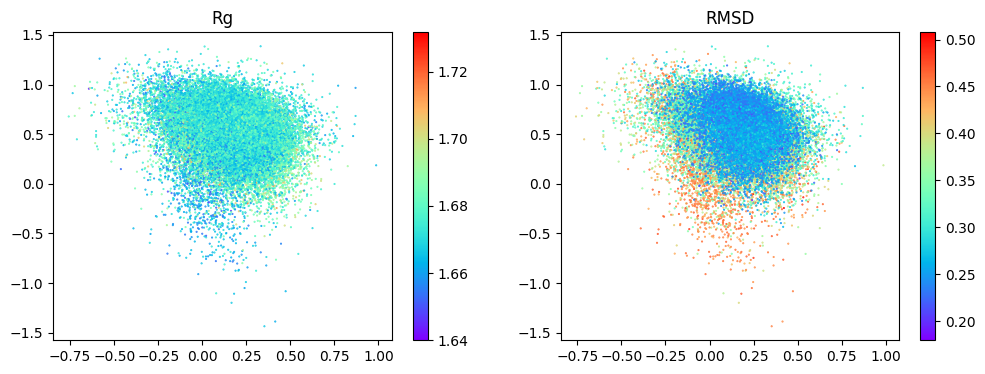

In [22]:
# visual check, should be the same as in train.ipynb
rg = md.compute_rg(x)
base = md.load(conf)
rmsd = md.rmsd(x,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(l[:,0],l[:,1],marker='.',c=rg,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(l[:,0],l[:,1],marker='.',c=rmsd,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

In [24]:
np.savetxt("lowdim_wt", l)